<a href="https://colab.research.google.com/github/ashishsaini01/Anomaly_detection_using_autoencoders/blob/main/Example_code_for_siamese_HOG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as k
import matplotlib.pyplot as plt
import random
import cv2

from google.colab.patches import cv2_imshow
from skimage.feature import hog
from skimage import color

In [ ]:
# mounting google drive for easy data reading
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = np.load('/content/drive/MyDrive/compress7.npz')
x, g, tx, ty, i, gi, ti = data['x'], data['gx'], data['tx'], data['ty'], data['i'], data['gi'], data['ti']

In [ ]:
data = np.load('/content/drive/MyDrive/full_0.npz')
# print(data.files)
x, g, tx, ty, i, gi, ti = data['x'], data['gx'], data['tx'], data['tn'], data['i'], data['gi'], data['ti']

In [ ]:
def hog_fun(x):
  image = color.rgb2gray(x) # coverting image into gray scale
  hog_descriptor, hog_image = hog(image, visualize = True) # calculating hog 
  return hog_descriptor

In [ ]:
hog_fun(x[0]).shape

(52164,)

In [ ]:
for i in x:
  arr = hog_fun(i)
  break

In [ ]:
arr

array([0.10027885, 0.09358282, 0.04012719, ..., 0.20752307, 0.11577806,
       0.03389037])

In [ ]:
x_hog = []
for h in x:
  arr = hog_fun(h)
  #arr = arr.reshape(52164)
  x_hog.append(arr)

In [ ]:
g_hog = []
for j in g:
  arr = hog_fun(j)
  #arr = arr.reshape(52164, 1)
  g_hog.append(arr)

tx_hog = []
for l in tx:
  arr = hog_fun(l)
  #arr = arr.reshape(52164, 1)
  tx_hog.append(arr)

In [ ]:
np.array(x_hog).shape, np.array(g_hog).shape, np.array(tx_hog[0]).shape

((3000, 52164), (202, 52164), (52164,))

In [ ]:
x_hog = np.array(x_hog)
g_hog = np.array(g_hog)
tx_hog = np.array(tx_hog)

In [ ]:
np.savez_compressed("hog_data.npz", x_hog = x_hog, g_hog = g_hog, tx_hog = tx_hog, ty=ty, i=i, gi=gi, ti=ti)

In [ ]:
data = np.load('/content/drive/MyDrive/hog_data.npz')
# print(data.files)
x_hog, g_hog, tx_hog, ty, i, gi, ti = data['x_hog'], data['g_hog'], data['tx_hog'], data['ty'], data['i'], data['gi'], data['ti']

In [ ]:
x_hog.shape, g_hog.shape #tx.shape, len(i), len(gi), ty.shape

((3000, 52164), (202, 52164))

In [ ]:
tx.shape, g.shape

((905, 32, 96, 3), (100, 32, 96, 3))

In [ ]:
# from re import X
def create_batch(batch_size=500):
    x_anchors = np.zeros((batch_size, 52164))
    x_positives = np.zeros((batch_size, 52164))
    x_negatives = np.zeros((batch_size, 52164))
    
    for j in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, x_hog.shape[0] - 1)
        x_anchor = x_hog[random_index]

        pos_index = random.randint(0, x_hog.shape[0] - 1)

        while pos_index == random_index or i[pos_index] != i[random_index]:
          pos_index = random.randint(0, x_hog.shape[0] - 1)

        x_positive = x_hog[pos_index]  # also for the same pallet block
        
        random_index_neg = random.randint(0, x_hog.shape[0] - 1)

        while random_index_neg == random_index or i[random_index] == i[random_index_neg]:
          random_index_neg = random.randint(0, x_hog.shape[0] - 1)
         
        x_negative = x_hog[random_index_neg]
        
        x_anchors[j] = x_anchor
        x_positives[j] = x_positive
        x_negatives[j] = x_negative
        
    x_anchors = np.expand_dims(x_anchors, axis = 1)
    x_positives = np.expand_dims(x_positives, axis = 1)
    x_negatives = np.expand_dims(x_negatives, axis = 1)

    k = np.concatenate([x_anchors, x_positives, x_negatives], axis = 1)
        
    return k

In [ ]:
examples = create_batch(1)
# plot_triplets(examples)

In [ ]:
# dim = 10
# alpha = 100

In [ ]:
input_shape = (4, 10, 128)
input_shape[1:]

(10, 128)

In [ ]:
# Embedding model
emb_size = 64

# embedding_model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(emb_size, (3, 3), activation = 'relu', strides = 2, padding = 'same', input_shape = (32, 96, 3)),
#     tf.keras.layers.Conv2D(emb_size/2, (3, 3), activation = 'relu', strides = 2, padding = 'same'),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(emb_size/2, activation = 'relu'),
#     tf.keras.layers.Dense(10, activation = 'sigmoid')
# ])

# model version 2

embedding_model = tf.keras.models.Sequential([
    # tf.keras.layers.Conv1D(emb_size*2, 3, activation = 'relu', strides = 2, padding = 'same', input_shape = (52164, 1)),
    # tf.keras.layers.Conv1D(emb_size, 3, activation = 'relu', padding = 'same'),
    # tf.keras.layers.MaxPool1D(pool_size = 2),
    # tf.keras.layers.Conv1D(emb_size/2, 5),
    # tf.keras.layers.Dropout(0.5),
    #tf.keras.Input(shape = (52164)),
    tf.keras.layers.Flatten(input_shape = (52164,)),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32)
])

embedding_model.summary()

# input_layer1 = tf.keras.layers.Input(shape = tri_data.shape[2:])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 52164)             0         
                                                                 
 dense (Dense)               (None, 128)               6677120   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
Total params: 6,697,760
Trainable params: 6,697,760
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow.keras.backend as k

In [ ]:
# siamese network
siamese_input = tf.keras.Input(shape = (3, 52164))
input_anchor =  siamese_input[:, 0]                                              #tf.keras.layers.Input(shape=(32, 96, 3))
input_positive = siamese_input[:, 1]                                             #tf.keras.layers.Input(shape=(32, 96, 3))
input_negative = siamese_input[:, 2]                                             #tf.keras.layers.Input(shape=(32, 96, 3))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

embedding_anchor = k.expand_dims(embedding_anchor, 1)
embedding_negative = k.expand_dims(embedding_negative, 1)
embedding_positive = k.expand_dims(embedding_positive, 1)


output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1) 

model = tf.keras.models.Model(siamese_input, output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 52164)]   0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 52164)       0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 52164)       0           ['input_1[0][0]']                
 icingOpLambda)                                                                                   
                                                                                              

In [ ]:
# alpha = 0.02
# alpha = 0.05
# alpha = 0.07
alpha = 0.001
# alpha = 1.0
# alpha = 0.01

# pos = k.sqrt(k.mean((embedding_anchor - embedding_positive)**2, axis = 1))
# neg = k.sqrt(k.mean((embedding_anchor - embedding_negative)**2, axis = 1))

pos = k.mean((embedding_anchor - embedding_positive)**2, axis = 1)
neg = k.mean((embedding_anchor - embedding_negative)**2, axis = 1)

loss = k.mean(k.relu(pos - neg + alpha)) 

In [ ]:
batch_size = 3000
x_train = create_batch(batch_size)
x_train = np.array(x_train)
x_train.shape

(3000, 3, 52164)

In [ ]:
# np.savez_compressed("/content/drive/MyDrive/x_train_data_20000", x = x_train)

In [ ]:
# batch_size = 2048
epochs = 25
# steps_per_epoch = 25

model.add_loss(loss)


model.compile(optimizer='adam')

callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3, mode = 'min') # for early stopping

history = model.fit(
    x_train,
    batch_size = 100,
    epochs=epochs, verbose=True, callbacks = [callback], validation_split = 0.2)

Epoch 1/25
24/24 [==============================] - 8s 95ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 2/25
24/24 [==============================] - 1s 56ms/step - loss: 0.0013 - val_loss: 9.5927e-04
Epoch 3/25
24/24 [==============================] - 1s 55ms/step - loss: 4.7967e-04 - val_loss: 7.6963e-04
Epoch 4/25
24/24 [==============================] - 1s 55ms/step - loss: 2.9037e-04 - val_loss: 6.9706e-04
Epoch 5/25
24/24 [==============================] - 1s 58ms/step - loss: 1.8030e-04 - val_loss: 8.1757e-04
Epoch 6/25
24/24 [==============================] - 2s 82ms/step - loss: 1.5365e-04 - val_loss: 8.6577e-04
Epoch 7/25
24/24 [==============================] - 3s 144ms/step - loss: 1.5715e-04 - val_loss: 8.5593e-04
Epoch 8/25
24/24 [==============================] - 2s 103ms/step - loss: 1.1036e-04 - val_loss: 9.4660e-04
Epoch 9/25
24/24 [==============================] - 2s 90ms/step - loss: 7.9772e-05 - val_loss: 0.0011
Epoch 10/25
24/24 [==============================] 

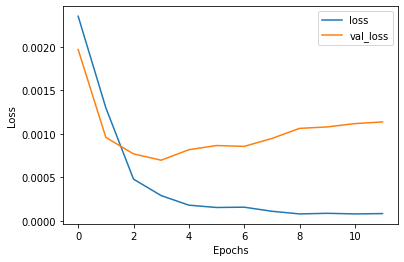

In [ ]:
# ploting 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
x_predict = embedding_model.predict(x_hog)
g_predict = embedding_model.predict(g_hog)
t_predict = embedding_model.predict(tx_hog)

26/26 [==============================] - 0s 4ms/step


In [ ]:
bool_ls = []
for n in range(0, t_predict.shape[0]):
  if ty[n] == 1: continue
  p_2 = t_predict[n]
  sub = g_predict - p_2
  dist = np.mean((sub)**2, axis = 1)
  min_index = np.argsort(dist)[:1]
  if (gi[min_index] == ti[n]).any(): bool_ls.append(1)
  else: bool_ls.append(0)

In [ ]:
np.mean(bool_ls)

0.04826732673267327

In [ ]:
# np.savez_compressed("/content/drive/MyDrive/compress_predictions.npz", x_pre = x_predict, g_pre = g_predict, t_pre = t_predict)

In [ ]:
x_predict.shape

(1505, 32)

In [ ]:
k.expand_dims(x[i[0]], axis = 0).shape

TensorShape([1, 32, 96, 3])

In [ ]:
x_1 = embedding_model.predict(k.expand_dims(x[gi[1]], axis = 0))
tx_1 = embedding_model.predict(k.expand_dims(tx[gi[1]], axis = 0))
g_1 = embedding_model.predict(k.expand_dims(g[1], axis = 0))
print(tx_1.shape, x_1.shape, g_1.shape)

1/1 [==============================] - 0s 18ms/step
(1, 10) (1, 10) (1, 10)


In [ ]:
i

array([407, 450, 306, ..., 291, 233, 186])

In [ ]:
np.where(ti == 216)

(array([294, 299, 309, 504]),)

In [ ]:
gi

array([ 98, 216, 468,  94, 331, 164, 445,  96, 114, 285,  77,  47, 197,
        55,  46, 345, 277, 139, 436,  97, 405, 265, 148, 262, 109, 274,
       222, 133, 185, 464, 396, 326, 410, 446, 444, 155, 195, 369, 212,
       371, 113,  58, 154, 492, 487, 346, 359, 358, 217, 387, 224, 328,
       318, 287, 244, 257,  73, 193, 219, 218,  10, 426, 337,  20, 272,
       146, 477, 283, 501, 166, 397, 220, 495, 240, 103, 297, 163, 172,
       389, 296, 179, 443, 470,   3, 360, 502, 173,  80,  29, 249, 236,
       116, 234, 367, 329,  18,  16,  34, 149, 366])

In [ ]:
matrix = np.corrcoef(x_1, tx_1)
matrix2 = np.corrcoef(x_1, g_1)
 
# print matrix
print(matrix, '\n\n', matrix2)

[[1.         0.06432306]
 [0.06432306 1.        ]] 

 [[1.         0.81642268]
 [0.81642268 1.        ]]


In [ ]:
predict_data = np.load('/content/drive/MyDrive/compress_predictions.npz')
x_pre, g_pre, t_pre = predict_data['x_pre'], predict_data['g_pre'], predict_data['t_pre']

In [ ]:
p_1 = g_pre[1] # j

In [ ]:
p_2 = t_pre[504] # i

In [ ]:
t_predict.shape

(905, 10)

In [ ]:
t_pre.shape

(905, 32)

In [ ]:
bool_ls = []
for n in range(0, t_predict.shape[0]):
  if ty[n] == 1: continue
  p_2 = t_predict[n]
  sub = g_predict - p_2
  dist = np.mean((sub)**2, axis = 1)
  min_index = np.argsort(dist)[:5]
  if (gi[min_index] == ti[n]).any(): bool_ls.append(1)
  else: bool_ls.append(0)

In [ ]:
np.mean(bool_ls)

0.3225

In [ ]:
sub = g_pre - p_2
dist = np.mean((sub)**2, axis = 1)
# sub.shape
np.argsort(dist)[0]

38

In [ ]:
np.mean((p_1 - p_2)**2)

0.00055384514

In [ ]:
matrix2 = np.corrcoef(p_1, p_2)
 
# print matrix
print(matrix2, '\n\n', matrix2)

[[1.         0.99949293]
 [0.99949293 1.        ]] 

 [[1.         0.99949293]
 [0.99949293 1.        ]]


In [ ]:
x_pre, g_pre, t_pre = x_predict, g_predict, t_predict

In [ ]:
x_pre[0]

array([0.8322267 , 0.83789957, 0.16034627, 0.8310014 , 0.15188247,
       0.84134567, 0.8393223 , 0.8219712 , 0.8312194 , 0.1728259 ,
       0.8349191 , 0.16590577, 0.16494566, 0.1809488 , 0.83093226,
       0.8198781 , 0.82493395, 0.16758806, 0.17763847, 0.15761149,
       0.15721014, 0.83669275, 0.83648694, 0.83631444, 0.8297453 ,
       0.17320329, 0.8239547 , 0.82927597, 0.16270399, 0.16562617,
       0.8344859 , 0.8441384 ], dtype=float32)

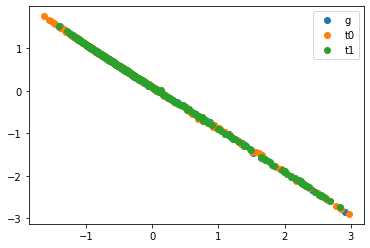

In [ ]:
g_pre1 = g_pre[:, :2]
t_pre1 = t_pre[:, :2]

t0 = t_pre1[ty == 0]
t1 = t_pre1[ty == 1]

plt.plot(g_pre[:,0],  g_pre[:,1], "o", label = "g")
plt.plot(t0[:,0], t0[:,1], "o", label = "t0")
plt.plot(t1[:,0], t1[:,1], "o", label = "t1")
plt.legend()

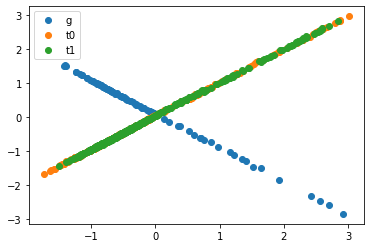

In [ ]:
g_pre1 = g_pre[:, 3:5]
t_pre1 = t_pre[:, 3:5]

t0 = t_pre1[ty == 0]
t1 = t_pre1[ty == 1]

plt.plot(g_pre[:,0],g_pre[:,1],"o",label="g")
plt.plot(t0[:,0],t0[:,1],"o",label="t0")
plt.plot(t1[:,0],t1[:,1],"o",label="t1")
plt.legend()

In [ ]:
g_pre1 = g_pre[:, 8:10]
t_pre1 = t_pre[:, 8:10]

t0 = t_pre1[ty == 0]
t1 = t_pre1[ty == 1]

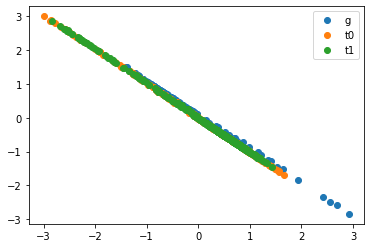

In [ ]:
plt.plot(g_pre[:,0],g_pre[:,1],"o",label="g")
plt.plot(t0[:,0],t0[:,1],"o",label="t0")
plt.plot(t1[:,0],t1[:,1],"o",label="t1")
plt.legend()

In [ ]:
# from sklearn.metrics import roc_auc_score
# roc_auc_score(ty, t_pre)
g[2].shape

(32, 96, 3)